In [2]:
import yfinance as yf
from IPython.display import display, HTML
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
printDF = lambda df: display(HTML(df.to_html())) #index=False

In [51]:
#https://pypi.org/project/yfinance/
data = yf.download(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        tickers = "^GDAXI",

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "3y",

#         start="2015-01-01", 
        
#         end="2015-01-10",
    
        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "1d")

data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-05-02,12478.459961,12511.169922,12433.509766,12507.900391,12507.900391,85263200
2017-05-03,12502.360352,12532.250000,12477.870117,12527.839844,12527.839844,79318800
2017-05-04,12552.059570,12648.219727,12539.709961,12647.780273,12647.780273,102442000
2017-05-05,12601.459961,12718.660156,12591.750000,12716.889648,12716.889648,104480300
2017-05-08,12758.480469,12762.040039,12659.700195,12694.549805,12694.549805,97719300


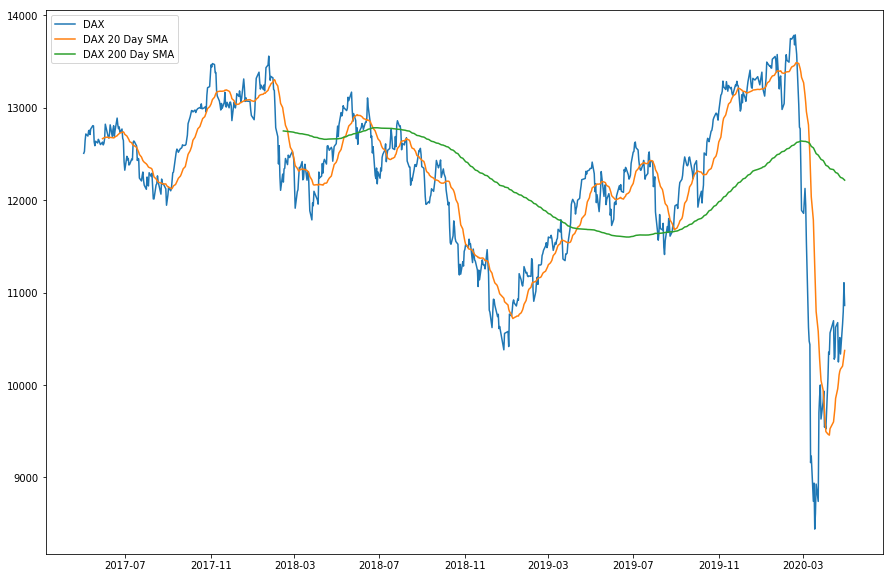

,Open,High,Low,Close,Adj Close,Volume,20 DAY SMA,200 DAY SMA
Date,,,,,,,,
2017-05-02,12478.459961,12511.169922,12433.509766,12507.900391,12507.900391,85263200,NaN,NaN
2017-05-03,12502.360352,12532.250000,12477.870117,12527.839844,12527.839844,79318800,NaN,NaN
2017-05-04,12552.059570,12648.219727,12539.709961,12647.780273,12647.780273,102442000,NaN,NaN
2017-05-05,12601.459961,12718.660156,12591.750000,12716.889648,12716.889648,104480300,NaN,NaN
2017-05-08,12758.480469,12762.040039,12659.700195,12694.549805,12694.549805,97719300,NaN,NaN
...,...,...,...,...,...,...,...,...
2020-04-24,10299.309570,10486.469727,10299.309570,10336.089844,10336.089844,120035000,10172.521436,12247.289199
2020-04-27,10551.070312,10660.360352,10523.099609,10659.990234,10659.990234,122476600,10205.472949,12238.722100
2020-04-28,10658.469727,10897.820312,10651.580078,10795.629883,10795.629883,146549900,10263.628467,12231.039648


In [52]:
df = data
data['20 DAY SMA'] = df.Close.rolling(window=20).mean()
data['200 DAY SMA'] = df.Close.rolling(window=200).mean()

fig, ax = plt.subplots(1, figsize=[15, 10])
ax.plot(data.index, data.Close, label='DAX')
ax.plot(data.index, data['20 DAY SMA'], label='DAX 20 Day SMA')
ax.plot(data.index, data['200 DAY SMA'], label='DAX 200 Day SMA')
ax.legend()
plt.show()

df

In [227]:
class Chart:
    def __init__(self, data):
        self.data = data
        self.current_i = 0
        self.listener = []
    def register_new_listener(self, listener):
        self.listener.append(listener)
    def keep_tracking(self):
        while len(self.data) - 1 > self.current_i:
            current_element = self.data.iloc[self.current_i]
            self.current_i = self.current_i + 1
            for i in self.listener:
                i.listen(current_element.name, current_element['Close'])

class SMAStrategy:
    def __init__(self, days):
        self.df = pd.DataFrame(columns=['value'])
        self.days = days
        self.name = "{} Days SMA".format(days)
    def recommend_to_invest(self, time, value):
        self.df.loc[time] = value
        self.df['mean'] = self.df['value'].rolling(window=self.days).mean()
        return self.df.iloc[len(self.df) - 1]['mean'] > self.df.iloc[len(self.df) - 2]['mean']

class Bot:
    def __init__(self, name, strategy):
        self.name = name
        self.budget = 0
        self.is_invested = False
        self.strategy = strategy
        self.df = pd.DataFrame(columns=['time', 'value', 'change', 'nr_of_decision', 'action', 'budget'])
        
    def listen(self, time, value):
        rec = self.strategy.recommend_to_invest(time, value)
        change = (value - self.df.iloc[-1]['value']) if self.df.size > 0 else np.NaN
        row = {'value': value, 'change': change}
        
        def get_nr_of_decision(is_increment):
            mx = self.df['nr_of_decision'].dropna().max()
            mx = 0 if np.isnan(mx) else mx
            return (1 if is_increment else 0) + mx
        def get_action():
            if rec and not self.is_invested:
                self.is_invested = True
                return 'in'
            elif not rec and self.is_invested:
                self.is_invested = False
                return 'out'
            elif rec and self.is_invested:
                return  'keep'
            elif not rec and not self.is_invested:
                return 'wait'
        
        row['action'] = get_action()
        row['nr_of_decision'] = get_nr_of_decision(row['action'] == 'in')
        if row['action'] in ['in', 'keep', 'out']:
            self.budget += change

        row['budget'] = self.budget
        row['time'] = time
        series = pd.Series(row)
        series.name = time
        self.df = self.df.append(series)

chart = Chart(data)
for i in np.arange(0, 200, 20) + 20:
    bot = Bot('SMA ' + str(i), SMAStrategy(i))
    chart.register_new_listener(bot)
chart.keep_tracking()
# printDF(larsBot.df)

In [262]:
from sklearn.model_selection import TimeSeriesSplit
train = data[:int(len(data) * 0.7)]
test = data[:int(len(data) * 0.3)]
# X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
# tscv = TimeSeriesSplit(n_splits=2)
# for train_index, test_index in tscv.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     print(y_train)

528

In [267]:
for i in chart.listener:
    printDF(i.df.head(20))
    aggr = i.df.groupby('nr_of_decision').agg({'time': ['min', 'max'], 'change': ['sum', 'count']}).sort_values([('time', 'max')], ascending=True)
    aggr['budget'] = aggr[('change', 'sum')].cumsum()
    print(i.name, 'balance:', aggr.iloc[-1]['budget'].values[0])
    aggr['is_profit'] = aggr[('change', 'sum')] > 0
#     aggr = aggr.groupby('is_profit').agg({('change', 'count'): ['count', 'mean', 'std']})
    printDF(aggr)

,time,value,change,nr_of_invest,action,budget
2017-05-02,2017-05-02,12507.900391,NaN,NaN,wait,0
2017-05-03,2017-05-03,12527.839844,19.939453,NaN,wait,0
2017-05-04,2017-05-04,12647.780273,119.940430,NaN,wait,0
2017-05-05,2017-05-05,12716.889648,69.109375,NaN,wait,0
2017-05-08,2017-05-08,12694.549805,-22.339844,NaN,wait,0
2017-05-09,2017-05-09,12749.120117,54.570312,NaN,wait,0
2017-05-10,2017-05-10,12757.459961,8.339844,NaN,wait,0
2017-05-11,2017-05-11,12711.059570,-46.400391,NaN,wait,0
2017-05-12,2017-05-12,12770.410156,59.350586,NaN,wait,0
2017-05-15,2017-05-15,12807.040039,36.629883,NaN,wait,0


KeyError: 'nr_of_decision'

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


,Close,SMA 10_budget,SMA 20_budget,SMA 30_budget,SMA 200_budget
2020-04-23,10513.790039,3441.77,2881.09,1835.54,-468.069
2020-04-24,10336.089844,3264.07,2703.39,1657.84,-468.069
2020-04-27,10659.990234,3587.97,3027.29,1981.74,-468.069
2020-04-28,10795.629883,3723.61,3162.93,2117.38,-468.069
2020-04-29,11107.740234,4035.72,3475.04,2429.49,-468.069


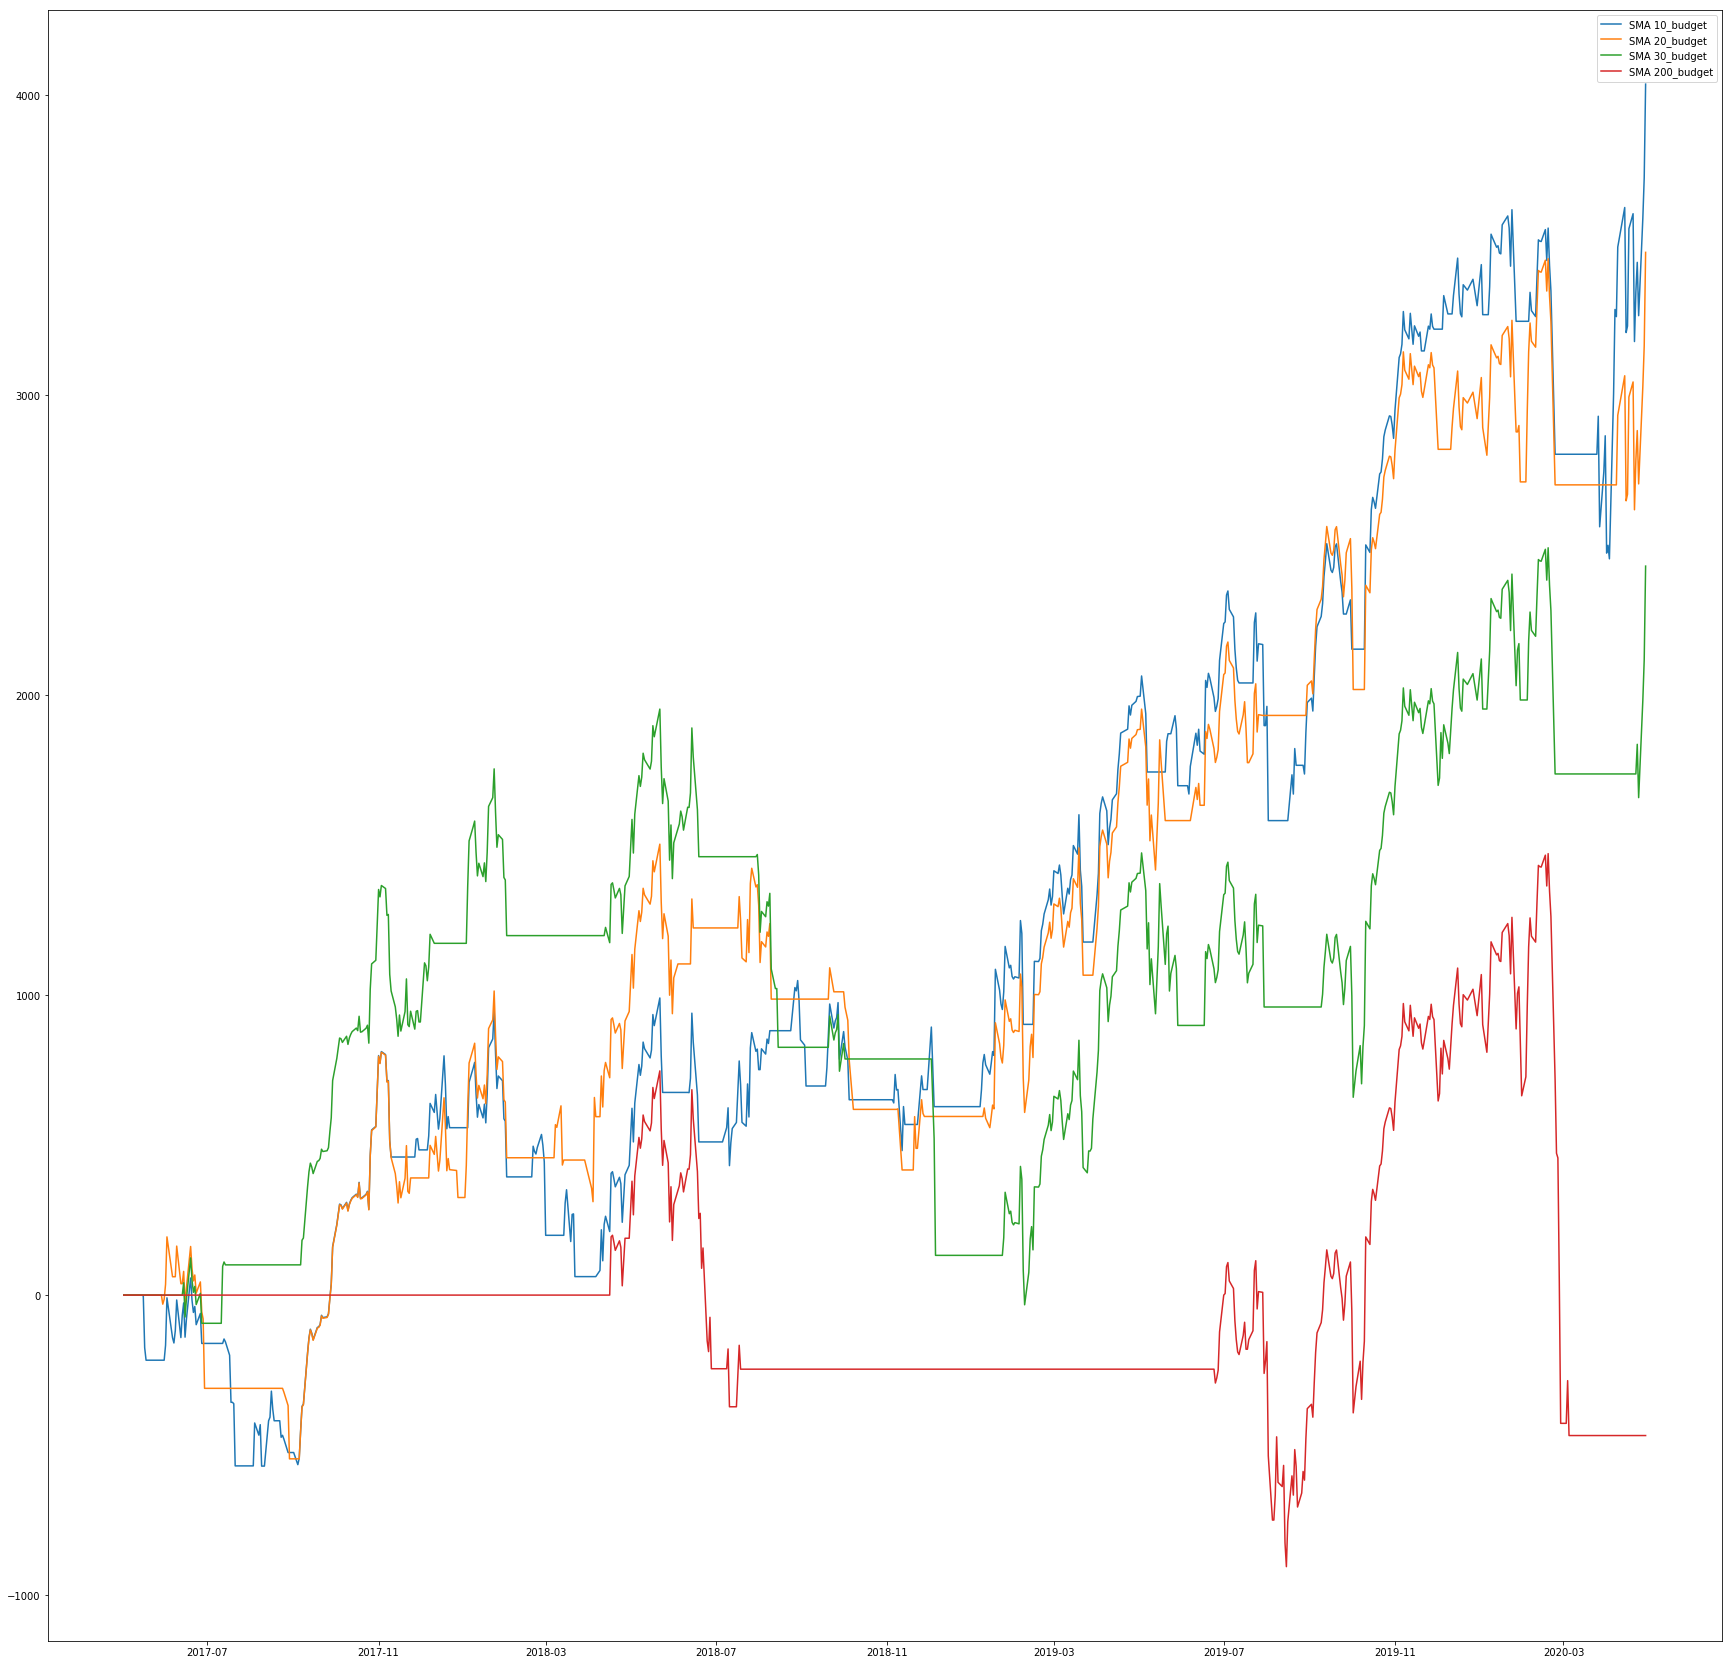

In [226]:
# result = pd.concat([lars.df, lars.strategy.df['mean']], axis=1, join='inner')
botDFs = [i.df.rename(columns={'budget': i.name + "_budget"})[i.name + "_budget"] for i in chart.listener]
result = pd.concat([data['Close']] + botDFs, axis=1, join='inner')
result = result.sort_values(result.last_valid_index(), axis=1, ascending=False)

fig, ax = plt.subplots(1, figsize=[30, 30])
for i in [i for i in result.columns if 'budget' in i]:
    ax.plot(result.index, result[i], label=i)
ax.legend()
fig.show()

printDF(result.tail(5))